In [4]:
import pandas as pd
import twint
import nest_asyncio
import re
import csv
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
import json
import pickle
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from string import punctuation
from wordcloud import WordCloud

In [6]:
data = pd.read_csv('Sentiment Analysis Dataset.csv',encoding='latin1')
data = data[['Sentiment','SentimentText']]

In [7]:
data['label'] = data['Sentiment']
data['tweet'] = data['SentimentText']

In [8]:
data = data[['label','tweet']][:50000]
data

,label,tweet
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
...,...,...
49995,0,@ashsimpsonwentz: oh so cute! Thank you for sh...
49996,0,@ashsnl2005 they are giving away red velvet ag...
49997,0,@AshSoPrecious Where were u @? Didn't know u w...
49998,0,@AshSoPrecious Y? I told u what happened. Fkn ...


In [9]:
positives = data['label'][data.label == 0]
negatives = data['label'][data.label == 1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of positve tagged sentences is:  23080
number of negative tagged sentences is: 26920
total length of the data is:            50000


In [10]:
data = data[['label','tweet']]

In [11]:
data.dtypes

label     int64
tweet    object
dtype: object

In [12]:
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [label, tweet]
Index: []


In [13]:
data.head()

,label,tweet
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [14]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it is very slow for a regular laptop

X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(data['tweet'][:5000], data['label'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.6min finished



Best Model: 0.711125 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.693175 Stdev:(0.009846) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.709300 Stdev:(0.007495) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.691050 Stdev:(0.010101) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.699050 Stdev:(0.008647) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.696550 Stdev:(0.005984) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.711125 Stdev:(0.005049) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.688825 Stdev:(0.006148) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.698100 Stdev:(0.006278) with: {'bow__ngram_range'

In [15]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [16]:
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.7054


confusion matrix: 
 [[3023 1549]
 [1397 4031]]


              precision    recall  f1-score   support

           0       0.68      0.66      0.67      4572
           1       0.72      0.74      0.73      5428

    accuracy                           0.71     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.71      0.70     10000



In [17]:
y_preds

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [18]:
tweet = pd.read_csv('Lockdown1.0.csv')

In [19]:
tweet.to_pickle('df_lockdown.p')

In [20]:
df_lockdown = pd.read_pickle('df_lockdown.p') 

In [21]:
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bhushan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    tweet = [lemma.lemmatize(word) for word in tweet]
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_lockdown['tweet'] = df_lockdown['tweet'].apply(processTweet)
# preview some cleaned tweets
df_lockdown['tweet'].head()

0    the jio company launched their new plans calle...
1    reliance jio offers free internet airtel voda ...
2        yes home only you can work from home you are 
3    apart from the jokes you may you need anyone t...
4                                      work from home 
Name: tweet, dtype: object

In [23]:
#Remove terms like word-word
before = df_lockdown['tweet'][100]
after = processTweet(before)

before,'\n',after

('let sonia gandhi rahul gandhi and robert vadra start distributing their accumulated wealth poor people charity begins from home why can start helping poor people one banglow occupied this family spared isolation ward for covid patients convey them …',
 '\n',
 'let sonia gandhi rahul gandhi and robert vadra start distributing their accumulated wealth poor people charity begins from home why can start helping poor people one banglow occupied this family spared isolation ward for covid patients convey them …')

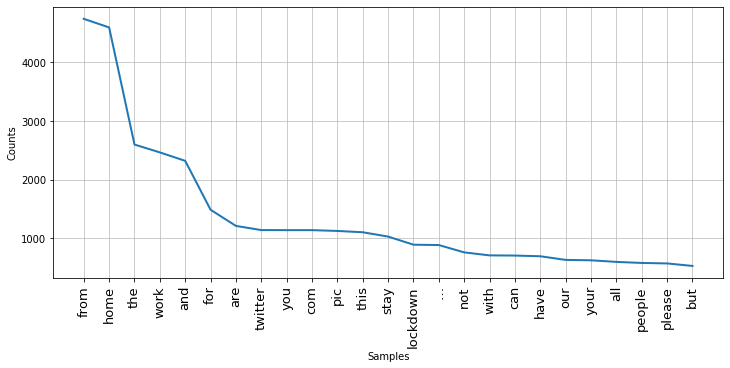

Text(0.5, 0, 'Word Rank')

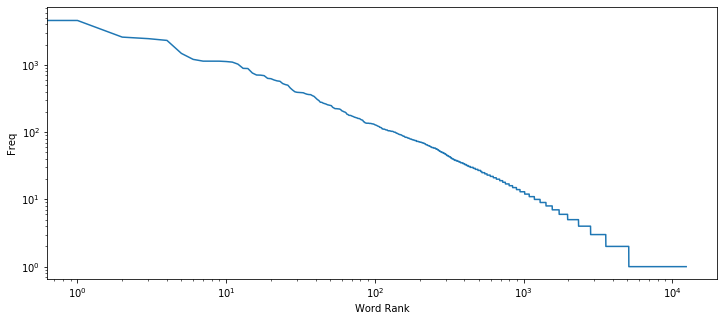

In [24]:
all_words = []
for line in list(df_lockdown['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [25]:
df_lockdown = df_lockdown.drop_duplicates('tweet')
df_lockdown.shape

(4074, 34)

In [26]:
# show stop words examples
nltk.download('stopwords')
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bhushan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

In [27]:
df_lockdown.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1242879759601799168,1242745110661435393,1585160600000,2020-03-25 23:53:20,530,NaN,the jio company launched their new plans calle...,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '853512722113323008', 'username':...",NaN,NaN,NaN,NaN
1,1,1242879607176478720,1242879607176478720,1585160564000,2020-03-25 23:52:44,530,NaN,reliance jio offers free internet airtel voda ...,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '869018357432950785', 'username':...",NaN,NaN,NaN,NaN
2,2,1242879202866515969,1242450477779800065,1585160468000,2020-03-25 23:51:08,530,NaN,yes home only you can work from home you are,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '804045415322554368', 'username':...",NaN,NaN,NaN,NaN
3,3,1242878275585802240,1242873807137726464,1585160247000,2020-03-25 23:47:27,530,NaN,apart from the jokes you may you need anyone t...,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '714465124782768128', 'username':...",NaN,NaN,NaN,NaN
4,4,1242876746459803658,1242717249590321157,1585159882000,2020-03-25 23:41:22,530,NaN,work from home,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '276394575', 'username': 'hiren_r...",NaN,NaN,NaN,NaN


In [28]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]
df_lockdown = df_lockdown.copy()
df_lockdown['tokens'] = df_lockdown['tweet'].apply(text_process) # tokenize style 1

In [29]:
df_lockdown.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,0,1242879759601799168,1242745110661435393,1585160600000,2020-03-25 23:53:20,530,NaN,the jio company launched their new plans calle...,[],[],...,NaN,NaN,NaN,NaN,"[{'user_id': '853512722113323008', 'username':...",NaN,NaN,NaN,NaN,"[jio, company, launched, new, plans, called, w..."
1,1,1242879607176478720,1242879607176478720,1585160564000,2020-03-25 23:52:44,530,NaN,reliance jio offers free internet airtel voda ...,[],[],...,NaN,NaN,NaN,NaN,"[{'user_id': '869018357432950785', 'username':...",NaN,NaN,NaN,NaN,"[reliance, jio, offers, free, internet, airtel..."
2,2,1242879202866515969,1242450477779800065,1585160468000,2020-03-25 23:51:08,530,NaN,yes home only you can work from home you are,[],[],...,NaN,NaN,NaN,NaN,"[{'user_id': '804045415322554368', 'username':...",NaN,NaN,NaN,NaN,"[yes, home, work, home]"
3,3,1242878275585802240,1242873807137726464,1585160247000,2020-03-25 23:47:27,530,NaN,apart from the jokes you may you need anyone t...,[],[],...,NaN,NaN,NaN,NaN,"[{'user_id': '714465124782768128', 'username':...",NaN,NaN,NaN,NaN,"[apart, jokes, may, need, anyone, talk, away, ..."
4,4,1242876746459803658,1242717249590321157,1585159882000,2020-03-25 23:41:22,530,NaN,work from home,[],[],...,NaN,NaN,NaN,NaN,"[{'user_id': '276394575', 'username': 'hiren_r...",NaN,NaN,NaN,NaN,"[work, home]"


In [30]:
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_lockdown['tweet'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

12304


In [31]:
bow_transformer.vocabulary_

{'jio': 5790,
 'company': 2687,
 'launched': 6290,
 'new': 7413,
 'plans': 8160,
 'called': 2228,
 'work': 11695,
 'home': 5109,
 'reliance': 8951,
 'offers': 7631,
 'free': 4454,
 'internet': 5594,
 'airtel': 1132,
 'voda': 11393,
 'idea': 5297,
 'promise': 8479,
 'normal': 7506,
 'needs': 7368,
 '…': 12233,
 'yes': 11871,
 'apart': 1313,
 'jokes': 5826,
 'may': 6830,
 'need': 7363,
 'anyone': 1304,
 'talk': 10447,
 'away': 1566,
 'lockdown': 6472,
 'know': 6119,
 'feels': 4243,
 'like': 6402,
 'hell': 5019,
 'comforting': 2654,
 'way': 11521,
 'helpful': 5024,
 'glad❤️': 4681,
 'time': 10711,
 'protect': 8497,
 'covid': 2937,
 'stage': 10075,
 'people': 8022,
 'stay': 10119,
 'best': 1844,
 'cure': 3025,
 'question': 8660,
 'economy': 3762,
 'staving': 10118,
 'mine': 6980,
 'putting': 8590,
 'kapoor': 5925,
 'kanika': 5916,
 'rana': 8755,
 'different': 3419,
 'corners': 2886,
 'gives': 4675,
 'fragrant': 4449,
 'calmness': 2235,
 'cheezein': 2450,
 'nahi': 7258,
 'mil': 6956,
 'rahi

In [32]:
# example of vectorized text
sample_tweet = df_lockdown['tweet'][10]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

mohalla clinic doctor from mohanpuri maujpur area gopal jha found request all those who visited there between 12th march 18th march follow home quarantine for days pic twitter com xouum13ekv


  (0, 110)	1
  (0, 186)	1
  (0, 1379)	1
  (0, 2576)	1
  (0, 2644)	1
  (0, 3130)	1
  (0, 3573)	1
  (0, 4386)	1
  (0, 4435)	1
  (0, 4726)	1
  (0, 5109)	1
  (0, 5775)	1
  (0, 6757)	2
  (0, 6825)	1
  (0, 7072)	1
  (0, 7076)	1
  (0, 8108)	1
  (0, 8647)	1
  (0, 9025)	1
  (0, 10950)	1
  (0, 11368)	1
  (0, 11815)	1




In [33]:
messages_bow = bow_transformer.transform(df_lockdown['tweet'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (4074, 12304)
Amount of Non-Zero occurences:  69503


In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 11815)	0.2780450775027658
  (0, 11368)	0.2295269102363274
  (0, 10950)	0.07349085707939222
  (0, 9025)	0.13855824527716704
  (0, 8647)	0.1139306173652864
  (0, 8108)	0.07394882764258097
  (0, 7076)	0.2780450775027658
  (0, 7072)	0.2649656814703137
  (0, 6825)	0.2780450775027658
  (0, 6757)	0.32579989892948097
  (0, 5775)	0.24848759123972988
  (0, 5109)	0.033615841424580455
  (0, 4726)	0.2780450775027658
  (0, 4435)	0.21096695189816309
  (0, 4386)	0.159050090433593
  (0, 3573)	0.20219497944415385
  (0, 3130)	0.1212784166755342
  (0, 2644)	0.07377632584261715
  (0, 2576)	0.2649656814703137
  (0, 1379)	0.16624820149509464
  (0, 186)	0.25568570230123155
  (0, 110)	0.24848759123972988


In [35]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4074, 12304)


In [36]:
# run predictions on twitter data
tweet_preds = model_NB.predict(df_lockdown['tweet'])

# append predictions to dataframe
df_tweet_preds = df_lockdown.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(4074, 36)

In [37]:
# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.tweet[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

1.0 -- when you can get the comfort your sofa and bed while working then why not work from home pic twitter com ybktsyeuo7 

1.0 -- work from home only covering usual beats and have weak body thaanga maaten  

0.0 -- when major events like the olympucs wimbledon ipl etc have been postponed govt private offices have introduced work from home rules why couldn these religious functions postponed the organisers are guilty negligence leading serious health hazzards for all  

0.0 -- amazed all the heartfelt wishes pouring since midnight love you all 
with all this there one gift that like from you all please please stay home till the lockdown ends that the best gift you all can give  

0.0 -- here what have done this lockdown with what had matter what not just for yourself but for everyone have installed project home protect from covid spread this kinda setup can adopted public places the govt takes necessary steps pic twitter com w4lv0ap2hs 

1.0 -- worried about post lockdown problems wor

C:\Users\Bhushan\Anaconda3\lib\site-packages\pandas\core\series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [38]:
pos =  df_tweet_preds['predictions']==0
neg =  df_tweet_preds['predictions']==1


In [39]:
positive = df_tweet_preds[pos]
nega = df_tweet_preds[neg]


In [40]:
pd.options.display.max_colwidth = 500
positive[['predictions', 'tweet']].sample(n=20)

,predictions,tweet
4086,0,zara modiji pouch\nwhy air lifted people from china iran when modiji doesn have enough resources was important form government and delay lockdown how about migrants workers and people dieing without food test for foreigners airport ppe …
2341,0,years boy stuck ichalkaranji from last days went for only days but lockdown stuck not eating anything wants return his home trouble have tried online application but its not working plz needful
2771,0,sir software engineer this lockdown doing work from home yesterday laptop charging port got damage due some unwanted accident unable work can repair pls help
2429,0,when its sunday you can play district cricket league nor chennai non division league practicing defence from home balcony practice what you lack during this quarantine time perfect… igshid 15vci818ffhbw …
2198,0,priyanka doing work from home and now don have internet let know can work here
320,0,this was old video more than months old and vijay bumbadia guy video home quarantine government came from usa recently
395,0,also companies giving work from home doesn’ understands that you can not force them work night when they’ work from home not work from where you are anyway are providing all resources work wifi etc most important our sleep from 11pm 5am
3117,0,explain your definition covid deaths please twitter home more learned gentry yaha par poor sidhe kam hain what are factors which must there certify that demise resulted from cov2 strain sars covid19 for one dies hepatitis then lever failure …
1473,0,dear friends from inst applied art you know have spend these days home due the lockdown our respected alumina hon chief minister shri uddhavji thackeray trying his best keep safe pic twitter com rjlkzslyya
3988,0,corona effect work from home boss “ called you this afternoon your wife picked the phone and told that you were cooking why did you not call back called you back sir your wife picked the phone and told that you were washing clothes


In [41]:
nega

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens,predictions
1,1,1242879607176478720,1242879607176478720,1585160564000,2020-03-25 23:52:44,530,NaN,reliance jio offers free internet airtel voda idea promise normal internet for work from home needs …,[],[],...,NaN,NaN,NaN,"[{'user_id': '869018357432950785', 'username': 'Dharmendra41049'}, {'user_id': '929129743', 'username': 'reliancejio'}, {'user_id': '4925291660', 'username': 'yogiputinnath'}, {'user_id': '845345249958514689', 'username': 'Real_Jyoti1'}, {'user_id': '253464983', 'username': 'sanishkumarhim'}]",NaN,NaN,NaN,NaN,"[reliance, jio, offers, free, internet, airtel, voda, idea, promise, normal, internet, work, home, needs, …]",1
2,2,1242879202866515969,1242450477779800065,1585160468000,2020-03-25 23:51:08,530,NaN,yes home only you can work from home you are,[],[],...,NaN,NaN,NaN,"[{'user_id': '804045415322554368', 'username': 'kbjadeja1333'}, {'user_id': '2447086974', 'username': 'PoonambenMaadam'}, {'user_id': '18839785', 'username': 'narendramodi'}, {'user_id': '471741741', 'username': 'PMOIndia'}]",NaN,NaN,NaN,NaN,"[yes, home, work, home]",1
5,5,1242876655770562560,1242873284372369410,1585159860000,2020-03-25 23:41:00,530,NaN,this the time protect ourselves from covid this stage people should stay home this the best cure question about economy staving,[],[],...,NaN,NaN,NaN,"[{'user_id': '1237698695748923393', 'username': 'SaharieNadeem'}, {'user_id': '307642463', 'username': 'yasmeen_9'}]",NaN,NaN,NaN,NaN,"[time, protect, covid, stage, people, stay, home, best, cure, question, economy, staving]",1
6,6,1242874426531516421,1242868816922791936,1585159329000,2020-03-25 23:32:09,530,NaN,yes these are mine putting kapoor not kanika rana different corners home gives you fragrant calmness cheezein nahi mil rahi wohiii khatam rahi hai gai hai working from home tough work,"['#lockdown21', '#ahmedabadlockdown']",[],...,NaN,NaN,NaN,"[{'user_id': '257816770', 'username': 'jaladhi11'}, {'user_id': '84823082', 'username': 'kumarmanish9'}]",NaN,NaN,NaN,NaN,"[yes, mine, putting, kapoor, kanika, rana, different, corners, home, gives, fragrant, calmness, cheezein, nahi, mil, rahi, wohiii, khatam, rahi, hai, gai, hai, working, home, tough, work]",1
7,7,1242874107504422912,1242874105461788672,1585159253000,2020-03-25 23:30:53,530,"Shivalik nagar, haridwar",prevent them coming out home local nagar nigam workers distributed the essential things and collect the money from door door this way local daily worker will get income and can quarantine the people hope you will see this suggestion thanks – shivalik nagar haridwar,[],[],...,NaN,NaN,NaN,"[{'user_id': '1242867651484975104', 'username': 'priyans05737463'}]",NaN,NaN,NaN,NaN,"[prevent, coming, home, local, nagar, nigam, workers, distributed, essential, things, collect, money, door, door, way, local, daily, worker, get, income, quarantine, people, hope, see, suggestion, thanks, –, shivalik, nagar, haridwar]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,4192,1250973091754160128,1250973091754160128,1587090201000,2020-04-17 07:53:21,530,NaN,interesting news during these hard times looks like work from home ahem working very well love unlocked pregnancy test pill sales surge bengaluru times india cms …,"['#lockdown', '#wfh', '#covid19', '#gettingjiggywithit', '#blr']",[],...,NaN,NaN,NaN,"[{'user_id': '17130728', 'username': 'SharathKumar'}]",NaN,NaN,NaN,NaN,"[interesting, news, hard, times, looks, like, work, home, ahem, working, well, love, unlocked, pregnancy, test, pill, sales, surge, bengaluru, times, india, cms, …]",1
4194,4194,1250968647519985664,1250968647519985664,1587089142000,2020-04-17 07:35:42,530,NaN,dear sir plz direct all the lpg distributors provide refill cylinders consumer door step here distributor chando peterwar bokaro forcing people collect cyl

In [42]:
df_tweet_preds.to_csv('Lockdown1.0labelled.csv')

In [43]:
positive

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens,predictions
0,0,1242879759601799168,1242745110661435393,1585160600000,2020-03-25 23:53:20,530,NaN,the jio company launched their new plans called work from home plans,[],[],...,NaN,NaN,NaN,"[{'user_id': '853512722113323008', 'username': 'BhanuPr72801466'}, {'user_id': '3073369844', 'username': 'veerbahadur086'}, {'user_id': '929129743', 'username': 'reliancejio'}]",NaN,NaN,NaN,NaN,"[jio, company, launched, new, plans, called, work, home, plans]",0
3,3,1242878275585802240,1242873807137726464,1585160247000,2020-03-25 23:47:27,530,NaN,apart from the jokes you may you need anyone talk was away from home before lockdown know feels like hell you need comforting any way helpful glad❤️,[],[],...,NaN,NaN,NaN,"[{'user_id': '714465124782768128', 'username': 'mevedika02'}, {'user_id': '71977143', 'username': 'Shakteamaan'}]",NaN,NaN,NaN,NaN,"[apart, jokes, may, need, anyone, talk, away, home, lockdown, know, feels, like, hell, need, comforting, way, helpful, glad❤️]",0
4,4,1242876746459803658,1242717249590321157,1585159882000,2020-03-25 23:41:22,530,NaN,work from home,[],[],...,NaN,NaN,NaN,"[{'user_id': '276394575', 'username': 'hiren_r'}, {'user_id': '473745411', 'username': 'SanaSecurities'}]",NaN,NaN,NaN,NaN,"[work, home]",0
8,8,1242873841363251207,1242862753813061632,1585159189000,2020-03-25 23:29:49,530,NaN,put home quarantine stamp hands take aadhaar pan bank details later check their health every week stop spread from hyderabad state 60000 airtravellers still not tested and escaped proper checks,['#coronavirusindia'],[],...,NaN,NaN,NaN,"[{'user_id': '797761076595068928', 'username': 'HydWatch'}, {'user_id': '118787224', 'username': 'KTRTRS'}, {'user_id': '2558684335', 'username': 'TelanganaCMO'}, {'user_id': '2965511647', 'username': 'ysjagan'}, {'user_id': '1205760060242063361', 'username': 'dgpapofficial'}, {'user_id': '2687516120', 'username': 'AndhraPradeshCM'}]",NaN,NaN,NaN,NaN,"[put, home, quarantine, stamp, hands, take, aadhaar, pan, bank, details, later, check, health, every, week, stop, spread, hyderabad, state, 60000, airtravellers, still, tested, escaped, proper, checks]",0
9,9,1242873018122145795,1242873018122145795,1585158993000,2020-03-25 23:26:33,530,NaN,just want ask there’ corresponding fine those companies that don’ comply work from home regulations thanks,[],[],...,NaN,NaN,NaN,"[{'user_id': '2410837254', 'username': 'CharmineRica'}, {'user_id': '21078655', 'username': 'lovindubai'}, {'user_id': '20578408', 'username': 'gulf_news'}, {'user_id': '18860860', 'username': 'khaleejtimes'}]",NaN,NaN,NaN,NaN,"[want, ask, there’, corresponding, fine, companies, don’, comply, work, home, regulations, thanks]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,4186,1250993056670576641,1250993056670576641,1587094961000,2020-04-17 09:12:41,530,NaN,respecting each other saluting there efforts protect ppl from which growing every day appreciative people need home and obey the orders our government pic twitter com hlzgi65zxi,"['#coronawarriorsindia', '#kalaburagi', '#covid_19', '#stayhome', '#staysafe', '#kalaburagifightscoronavirus']",[],...,NaN,NaN,NaN,"[{'user_id': '861637483603382272', 'username': 'VeerPatilRaikod'}]",NaN,NaN,NaN,NaN,"[respecting, saluting, efforts, protect, ppl, growing, every, day, appreciative, people, need, home, obey, orders, government, pic, twitter, com, hlzgi65zxi]",0
4187,4187,1250992585285353472,1250992560094408704,1587094849000,2020-04-17 09:10:49,530,Ardee Residency,have high speed plan for which pay pretty high monthly fee this affecting work from home can even get call with all other browsers closed and have decent uninterrupted meeting how can you call yourself premium service provider ‍♂️ pic twitter com iudxoffq7f – ardee residency,[],[],...,NaN,NaN,NaN,"[{'user_id': '277